# Advanced genetic architectures

Here we consider more complicated genetic architecture components.

## Paritially overlapping non-infinitessimal models

Here we consider genetic effects for two traits, $Y$, $Z$, such that genome is partitioned into 5 sets:

 1. variants causal for $Y$ but not $Z$ 
 2. variants causal for $Z$ but not $Y$
 3. variants causal for $Y$ and $Z$ with orthogonal effects
 4. variants causal for $Y$ and $Z$ with correlated effects with r = 0.5
 5. non-causal variants
 
We'll have the heritabilities be 0.5 and 0.4 for $Y$ and $Z$, respectively, and have each causal set for the two variables account for one third of the total heritability.
 
The simplest way to achieve this is to manually construct a set of effects:
 

In [2]:
import xftsim as xft
import numpy as np
np.random.seed(123)

h2_y, h2_z = 0.5, 0.4
r_yz=.5

## our haplotypes
haplotypes = xft.sim.DemoSimulation(n=8000,m=2000).haplotypes

## divide genome into five equally sized components
variant_set_indices = [np.sort(x) for x in np.array_split(np.random.permutation(haplotypes.xft.m), 5)]

In [3]:
## initialize effects matrix
beta = np.zeros((haplotypes.xft.m, 2))

##  1. variants causal for $Y$ but not $Z$ 
beta[variant_set_indices[0],0] = np.random.randn(len(variant_set_indices[0]))*np.sqrt(h2_y/3 / len(variant_set_indices[0]))
##  2. variants causal for $Z$ but not $Y$
beta[variant_set_indices[1],1] = np.random.randn(len(variant_set_indices[1]))*np.sqrt(h2_z/3 / len(variant_set_indices[1]))
## 3. variants causal for $Y$ and $Z$ with orthogonal effects
beta[variant_set_indices[2],0] = np.random.randn(len(variant_set_indices[2]))*np.sqrt(h2_y/3 / len(variant_set_indices[2]))
beta[variant_set_indices[2],1] = np.random.randn(len(variant_set_indices[2]))*np.sqrt(h2_z/3 / len(variant_set_indices[2]))
## 4. variants causal for $Y$ and $Z$ with correlated effects
cov = np.array([[h2_y/3, r_yz*np.sqrt(h2_y*h2_z)/3],
                [r_yz*np.sqrt(h2_y*h2_z)/3,h2_z/3]])/len(variant_set_indices[3])
beta[variant_set_indices[3],:] = np.random.multivariate_normal(mean = np.zeros(2),
                                                               cov = cov,
                                                               size = len(variant_set_indices[3]))
## 5. non-causal variants are already zero

We can verify that the effects are what we wanted:

In [4]:
G_std = haplotypes.xft.to_diploid_standardized(af= haplotypes.af[::2], scale = False)
print('Total genetic covariance matrix:')
print(np.cov(G_std@beta, rowvar=False))
for i,variant_set in enumerate(variant_set_indices):
    print(f"\nSet {i} genetic covariance matrix::")
    print(np.cov(G_std[:,variant_set]@beta[variant_set,:], rowvar=False))


Total genetic covariance matrix:
[[0.48917589 0.08108774]
 [0.08108774 0.40524652]]

Set 0 genetic covariance matrix::
[[0.18204683 0.        ]
 [0.         0.        ]]

Set 1 genetic covariance matrix::
[[0.         0.        ]
 [0.         0.13145234]]

Set 2 genetic covariance matrix::
[[0.14914447 0.00302548]
 [0.00302548 0.14336695]]

Set 3 genetic covariance matrix::
[[0.1565706  0.07178822]
 [0.07178822 0.12704674]]

Set 4 genetic covariance matrix::
[[0. 0.]
 [0. 0.]]


Finally, we can construct the additive effects component:

In [5]:
add_effects_object = xft.effect.AdditiveEffects(scaled=False, standardized=True,
                                                beta=beta,
                                                variant_indexer=haplotypes.xft.get_variant_indexer(),
                                                component_indexer=xft.index.ComponentIndex.from_product(['y','z'],
                                                                                                        ['addGen']))

add_comp = xft.arch.AdditiveGeneticComponent(beta=add_effects_object)

We can then construct the noise and sum transformations needed to complete the phenogenetic architecture:

In [6]:
noise_comp = xft.arch.AdditiveNoiseComponent(variances=[1-h2_y,1-h2_z],
    component_index=xft.index.ComponentIndex.from_product(['y','z'],
                                                          ['noise']))
sum_trans = xft.arch.SumAllTransformation(xft.index.ComponentIndex.from_product(['y','z'],
                                                                                ['addGen','noise']))
arch = xft.arch.Architecture([add_comp,noise_comp,sum_trans])

Finally, we run a simulation assuming linear assortative mating on $Y$ and $Z$ with an exchangeable cross-mate correlation structure with $r_\text{mate}$ = 0.5:

In [7]:
rmap = xft.reproduce.RecombinationMap.constant_map_from_haplotypes(haplotypes, p=.1)
mate = xft.mate.LinearAssortativeMatingRegime(mates_per_female=2,
                                              offspring_per_pair=1,
                                              r=.5,
    component_index=xft.index.ComponentIndex.from_product(['y','z'],
                                                          ['phenotype']))
sim = xft.sim.Simulation(founder_haplotypes=haplotypes,
                         mating_regime=mate,
                         recombination_map=rmap,
                         architecture=arch,
                         statistics=[xft.stats.SampleStatistics(),
                                     xft.stats.MatingStatistics(),
                                     xft.stats.HasemanElstonEstimator(randomized=True)])
sim.run(5)

We can see inflation in HE regression correlation estimates increasing with each generation of cross-trait assortative mating:

In [8]:
xft.utils.print_tree(sim.results)
sim.results['HE_regression']['cov_HE']

sample_statistics: 
|__means: <class 'pandas.core.series.Series'>
|__variances: <class 'pandas.core.series.Series'>
|__variance_components: <class 'pandas.core.series.Series'>
|__vcov: <class 'pandas.core.frame.DataFrame'>
|__corr: <class 'pandas.core.frame.DataFrame'>
mating_statistics: 
|__n_reproducing_pairs: <class 'numpy.int64'>
|__n_total_offspring: <class 'numpy.int64'>
|__mean_n_offspring_per_pair: <class 'numpy.float64'>
|__mean_n_female_offspring_per_pair: <class 'numpy.float64'>
|__mate_correlations: <class 'pandas.core.frame.DataFrame'>
HE_regression: 
|__cov_HE: <class 'pandas.core.frame.DataFrame'>
|__corr_HE: <class 'pandas.core.frame.DataFrame'>


,,phenotype_name,y,z
,,component_name,phenotype,phenotype
,,vorigin_relative,proband,proband
phenotype_name,component_name,vorigin_relative,,
y,phenotype,proband,0.879744,0.465691
z,phenotype,proband,0.465691,0.699286


<Axes: xlabel='generation', ylabel='genetic correlation measure'>

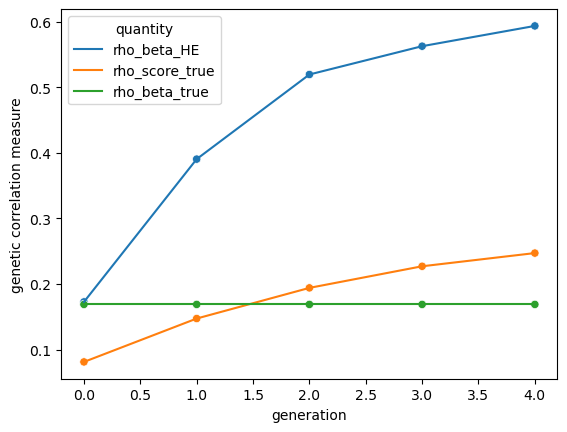

In [9]:
import seaborn as sns
import pandas as pd

results = pd.DataFrame.from_records([{'generation':key, 
  'rho_beta_HE':value['HE_regression']['corr_HE'].iloc[1,0],
  'rho_score_true':value['sample_statistics']['vcov'].iloc[1,0],
  'rho_beta_true':sim.architecture.components[0].true_rho_beta[1,0]} for key,value in sim.results_store.items()]
                         )

pdat = pd.melt(results, id_vars='generation', var_name='quantity',
               value_name='genetic correlation measure')
sns.lineplot(data=pdat, 
           x='generation',
           y='genetic correlation measure',
           hue='quantity',)
sns.scatterplot(data=pdat, 
           x='generation',
           y='genetic correlation measure',
           hue='quantity',legend=False)

In [11]:
xft.io.write_to_plink1(sim.haplotypes,'/tmp/test')

/home/rsb/Dropbox/ftsim/xftsim/xftsim/io.py:194: UserWarning: Writing to the plink bfile format removes phase information
  warnings.warn("Writing to the plink bfile format removes phase information")
Writing BED: 100%|████| 1/1 [00:00<00:00,  3.00it/s]

Writing FAM... done.
Writing BIM... done.



/home/rsb/mambaforge/lib/python3.10/site-packages/pandas_plink/_write.py:261: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  df.to_csv(
/home/rsb/mambaforge/lib/python3.10/site-packages/pandas_plink/_write.py:288: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  df.to_csv(
